In [1]:
import xarray as xr
import datetime

In [2]:
# load data
dataset = xr.open_dataset('/home/joao/Downloads/ERA5_20160823.nc')

In [3]:
# print variables of file
print(dataset)

<xarray.Dataset>
Dimensions:    (latitude: 721, level: 19, longitude: 1440, time: 4)
Coordinates:
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.25 359.5 359.75
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * level      (level) int32 100 150 200 250 300 350 ... 800 850 900 950 1000
  * time       (time) datetime64[ns] 2016-08-23 ... 2016-08-23T18:00:00
Data variables:
    t          (time, level, latitude, longitude) float32 ...
    u          (time, level, latitude, longitude) float32 ...
    v          (time, level, latitude, longitude) float32 ...
    vo         (time, level, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2019-08-11 03:21:07 GMT by grib_to_netcdf-2.10.0: /opt/ecmw...


In [4]:
# gets fields
uwind = dataset['u']
vwind = dataset['v']

In [5]:
# define the region of interest
Lon0, Lon1 = 310.0, 340.0 # longitud
Lat0, Lat1 = -50.0, -10.0 # latitud
Lev0, Lev1 = 1000, 200 # pressure level
Time0, Time1 = datetime.datetime(2016,8,23,0,0), datetime.datetime(2016,8,23,18,0) # DateTime

In [6]:
# select region of interest
# here the uwind and vwind are slice but keeping their 4D array
uwind = uwind.sel(time=slice(Time0, Time1), level=slice(Lev1, Lev0),
                  latitude=slice(Lat1, Lat0), longitude=slice(Lon0, Lon1))
vwind = vwind.sel(time=slice(Time0, Time1), level=slice(Lev1, Lev0),
                  latitude=slice(Lat1, Lat0), longitude=slice(Lon0, Lon1))

# check the shape of the uwind and vwind
print(uwind.shape, vwind.shape)

(4, 17, 161, 121) (4, 17, 161, 121)


In [7]:
# calculate vorticity and divergence
import metlib

vor = metlib.relative_vorticity(uwind, vwind)*1.0e5

In [8]:
# creates a custom color palette with custom_color_palette package
# see https://github.com/joaohenry23/custom_color_palette

import numpy as np
import matplotlib.pyplot as plt
import custom_color_palette as ccpl

mypalette, colorslabels, norm = ccpl.creates_palette([plt.cm.bwr],[-5.5,5.5])

# creating colorbar labels
tickslabels = np.arange(-5.5, 6.5, 1.0)

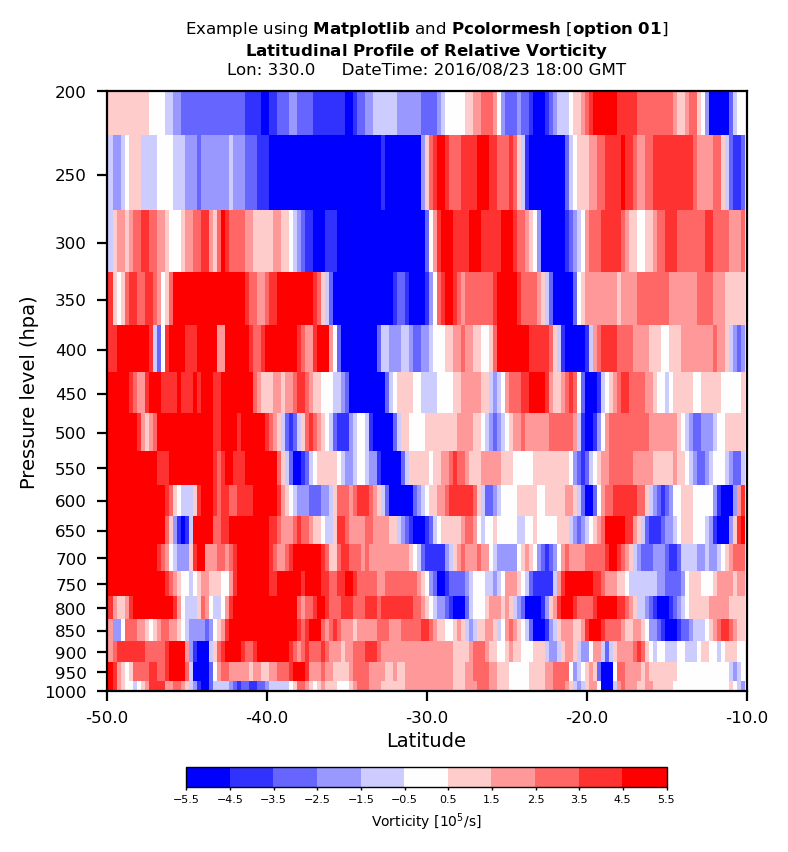

In [9]:
# PLOTTING LATITUDINAL PROFILE OF VORTICITY [OPTION 01: USING MATPLOTLIB AND PCOLORMESH]

# define the profile
LonPro0 = 330.0 # longitud
LatPro0, LatPro1 = -50.0, -10.0 # latitud
LevPro0, LevPro1 = 1000, 200 # pressure level
TimePro0 = datetime.datetime(2016,8,23,18,0) # DateTime

# here vor is slice, passing from 4D array to 2D array !
vorProf = vor.sel(time=TimePro0, level=slice(LevPro1, LevPro0),
                  latitude=slice(LatPro1, LatPro0), longitude=LonPro0)

# gets lats and levs
latsProf = vorProf['latitude'].values
levsProf = vorProf['level'].values

# calculate corners of latsProf and levsProf
latsProfCor = np.concatenate((latsProf+(latsProf[0]-latsProf[1])/2.0,
                              [latsProf[-1]-(latsProf[0]-latsProf[1])/2.0]))
levsProfCor = np.concatenate((levsProf+(levsProf[0]-levsProf[1])/2.0,
                              [levsProf[-1]-(levsProf[0]-levsProf[1])/2.0]))

# creates 2D array of latsProfCor and levsProfCor
latsProfCor2D, levsProfCor2D = np.meshgrid(latsProfCor, levsProfCor)


# creates figure
fig = plt.figure('Latitudinal Profile of Vorticity Matplotlib Pcolormesh',figsize=(4,4), dpi=200)
ax = fig.add_axes([0.1, 0.15, 0.80, 0.75])

# plot image 
img = ax.pcolormesh(latsProfCor2D, levsProfCor2D, vorProf, cmap=mypalette, norm=norm)

# customizing the plot border
plt.rcParams['axes.linewidth'] = 1.0

# plot colorbar
cbar = plt.colorbar(img, ticks=tickslabels, extend='neither',
                    spacing='proportional', orientation='horizontal',
                    cax=fig.add_axes([0.20, 0.03, 0.60, 0.025]))
cbar.ax.tick_params(labelsize=4, labelcolor='black',
                    width=0.5, length=1.2, direction='out', pad=1.5)
cbar.set_label(r'Vorticity [$10^{5}$/s]', size=5, color='black',
               weight='normal', labelpad=2.0)
cbar.outline.set_linewidth(0.5)


# sets labels
xticks = np.arange(-50.0,0.0,10.0)
ax.set_xticks(xticks)
ax.set_xticklabels(xticks, size=6)
ax.set_xlim(xticks.min(),xticks.max())
ax.set_xlabel('Latitude', fontdict={'fontsize':7}, labelpad=2.0)

yticks = np.arange(1000,150,-50)
ax.set_yscale("log")
ax.set_yticks(yticks)
ax.set_yticklabels(yticks, size=6)
ax.set_ylim(yticks.max(),yticks.min())
ax.set_ylabel('Pressure level (hpa)', fontdict={'fontsize':7}, labelpad=2.0)

ax.set_title('{}\n{}\nLon: {}     DateTime: {}'
             .format(r'Example using $\bf{Matplotlib}$ and $\bf{Pcolormesh}$ [$\bf{option}$ $\bf{01}$]',
                     r'$\bf{Latitudinal}$ $\bf{Profile}$ $\bf{of}$ $\bf{Relative}$ $\bf{Vorticity}$',
                     LonPro0, TimePro0.strftime('%Y/%m/%d %H:%M GMT')),
             fontdict={'fontsize':6}, pad=6.0)

plt.show()

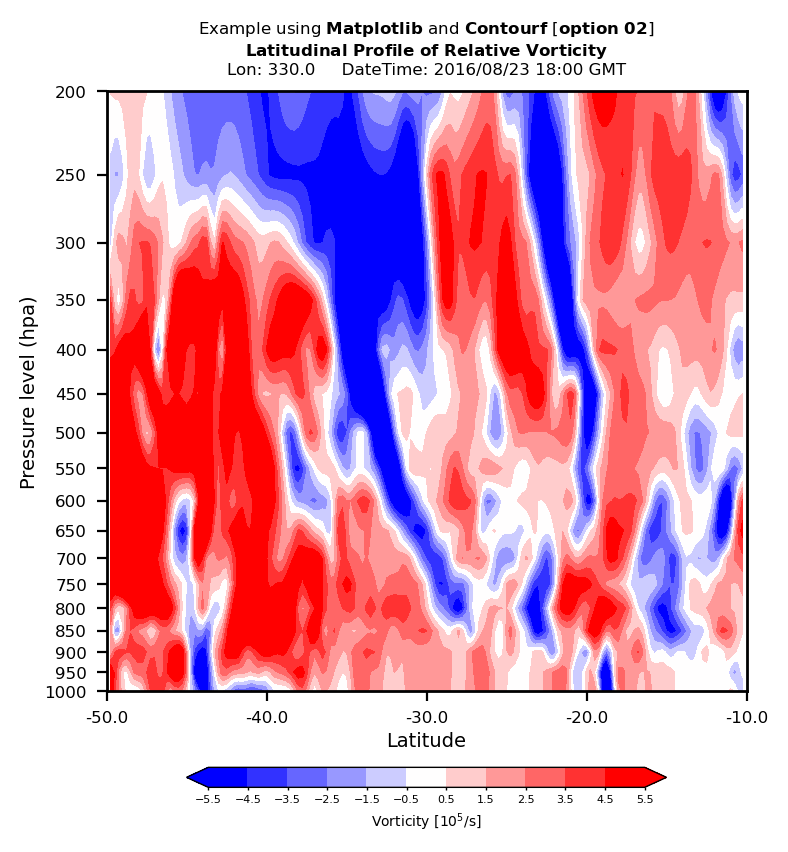

In [10]:
# PLOTTING LATITUDINAL PROFILE OF VORTICITY [OPTION 02: USING MATPLOTLIB AND CONTOURF]

# define the profile
LonPro0 = 330.0 # longitud
LatPro0, LatPro1 = -50.0, -10.0 # latitud
LevPro0, LevPro1 = 1000, 200 # pressure level
TimePro0 = datetime.datetime(2016,8,23,18,0) # DateTime

# here vor is slice, passing from 4D array to 2D array !
vorProf = vor.sel(time=TimePro0, level=slice(LevPro1, LevPro0),
                  latitude=slice(LatPro1, LatPro0), longitude=LonPro0)

# gets lats and levs
latsProf = vorProf['latitude'].values
levsProf = vorProf['level'].values

# creates 2D array of latsProf and levsProf
latsProfCen2D, levsProfCen2D = np.meshgrid(latsProf, levsProf)


# creates figure
fig = plt.figure('Latitudinal Profile of Vorticity Matplotlib Contourf',figsize=(4,4), dpi=200)
ax = fig.add_axes([0.1, 0.15, 0.80, 0.75])

# plot image
img = ax.contourf(latsProfCen2D, levsProfCen2D, vorProf, cmap=mypalette,
                  levels=tickslabels, extend='both')

# customizing the plot border
plt.rcParams['axes.linewidth'] = 1.0

# plot colorbar
cbar = plt.colorbar(img, ticks=tickslabels, extend='neither',
                    spacing='proportional', orientation='horizontal',
                    cax=fig.add_axes([0.20, 0.03, 0.60, 0.025]))
cbar.ax.tick_params(labelsize=4, labelcolor='black',
                    width=0.5, length=1.2, direction='out', pad=1.5)
cbar.set_label(r'Vorticity [$10^{5}$/s]', size=5, color='black',
               weight='normal', labelpad=2.0)
cbar.outline.set_linewidth(0.5)


# sets labels
xticks = np.arange(-50.0,0.0,10.0)
ax.set_xticks(xticks)
ax.set_xticklabels(xticks, size=6)
ax.set_xlim(xticks.min(),xticks.max())
ax.set_xlabel('Latitude', fontdict={'fontsize':7}, labelpad=2.0)

yticks = np.arange(1000,150,-50)
ax.set_yscale("log")
ax.set_yticks(yticks)
ax.set_yticklabels(yticks, size=6)
ax.set_ylim(yticks.max(),yticks.min())
ax.set_ylabel('Pressure level (hpa)', fontdict={'fontsize':7}, labelpad=2.0)

ax.set_title('{}\n{}\nLon: {}     DateTime: {}'
             .format(r'Example using $\bf{Matplotlib}$ and $\bf{Contourf}$ [$\bf{option}$ $\bf{02}$]',
                     r'$\bf{Latitudinal}$ $\bf{Profile}$ $\bf{of}$ $\bf{Relative}$ $\bf{Vorticity}$',
                     LonPro0, TimePro0.strftime('%Y/%m/%d %H:%M GMT')),
             fontdict={'fontsize':6}, pad=6.0)

plt.show()

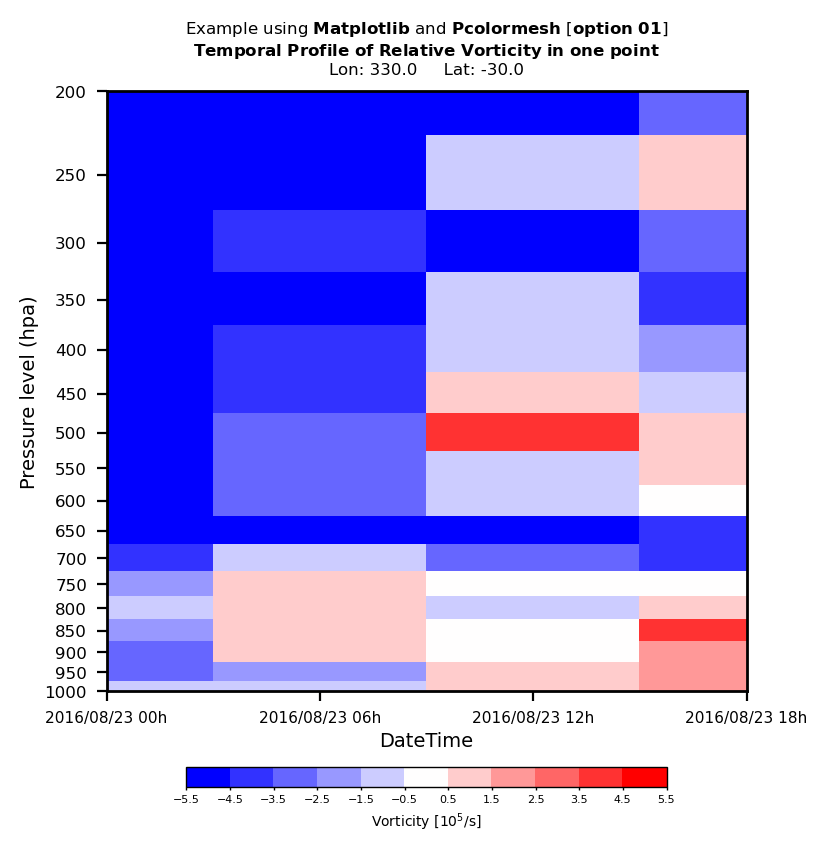

In [11]:
# PLOTTING TEMPORAL PROFILE OF VORTICITY IN ONE POINT [OPTION 01: USING MATPLOTLIB AND PCOLORMESH]

# define the profile
LonPro0 = 330.0 # longitud
LatPro0 = -30.0 # latitud
LevPro0, LevPro1 = 1000, 200 # pressure level
TimePro0, TimePro1 = datetime.datetime(2016,8,23,0,0), datetime.datetime(2016,8,23,18,0) # DateTime

# here vor is slice, passing from 4D array to 2D array !
vorProf = vor.sel(time=slice(TimePro0, TimePro1), level=slice(LevPro1, LevPro0),
                  latitude=LatPro0, longitude=LonPro0)

# here transpose vorProf array
vorProf = (vorProf.T)

# gets time and levs
timesProf = vorProf['time'].values.astype('datetime64[s]')
levsProf = vorProf['level'].values

# calculate corners of timesProf and levsProf
timesProfCor = np.concatenate((timesProf+(timesProf[0]-timesProf[1])/2.0,
                              [timesProf[-1]-(timesProf[0]-timesProf[1])/2.0]))
levsProfCor = np.concatenate((levsProf+(levsProf[0]-levsProf[1])/2.0,
                              [levsProf[-1]-(levsProf[0]-levsProf[1])/2.0]))

# creates 2D array of timesProfCor and levsProfCor
timesProfCor2D, levsProfCor2D = np.meshgrid(timesProfCor, levsProfCor)


# creates figure
fig = plt.figure('Temporal Profile of Vorticity Matplotlib Pcolormesh',figsize=(4,4), dpi=200)
ax = fig.add_axes([0.1, 0.15, 0.80, 0.75])

# plot image 
img = ax.pcolormesh(timesProfCor2D, levsProfCor2D, vorProf, cmap=mypalette, norm=norm)

# customizing the plot border
plt.rcParams['axes.linewidth'] = 1.0

# plot colorbar
cbar = plt.colorbar(img, ticks=tickslabels, extend='neither',
                    spacing='proportional', orientation='horizontal',
                    cax=fig.add_axes([0.20, 0.03, 0.60, 0.025]))
cbar.ax.tick_params(labelsize=4, labelcolor='black',
                    width=0.5, length=1.2, direction='out', pad=1.5)
cbar.set_label(r'Vorticity [$10^{5}$/s]', size=5, color='black',
               weight='normal', labelpad=2.0)
cbar.outline.set_linewidth(0.5)


# sets labels
xticks = [time.strftime('%Y/%m/%d %Hh') for time in timesProf.tolist()]
ax.set_xticks(timesProf)
ax.set_xticklabels(xticks, size=5.5)
ax.set_xlim(timesProf.min(),timesProf.max())
ax.set_xlabel('DateTime', fontdict={'fontsize':7}, labelpad=2.0)

yticks = np.arange(1000,150,-50)
ax.set_yscale("log")
ax.set_yticks(yticks)
ax.set_yticklabels(yticks, size=6)
ax.set_ylim(yticks.max(),yticks.min())
ax.set_ylabel('Pressure level (hpa)', fontdict={'fontsize':7}, labelpad=2.0)

ax.set_title('{}\n{}\nLon: {}     Lat: {}'
             .format(r'Example using $\bf{Matplotlib}$ and $\bf{Pcolormesh}$ [$\bf{option}$ $\bf{01}$]',
                     r'$\bf{Temporal}$ $\bf{Profile}$ $\bf{of}$ $\bf{Relative}$ $\bf{Vorticity}$ '+
                     r'$\bf{in}$ $\bf{one}$ $\bf{point}$',
                     LonPro0, LatPro0),
             fontdict={'fontsize':6}, pad=6.0)

plt.show()

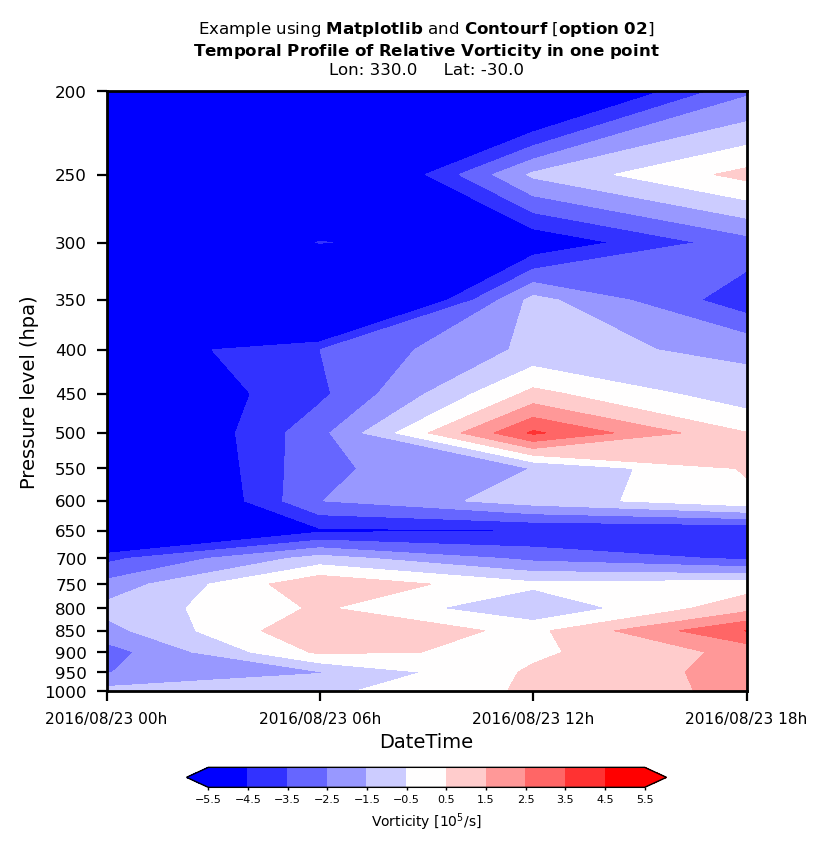

In [12]:
# PLOTTING TEMPORAL PROFILE OF VORTICITY IN ONE POINT [OPTION 02: USING MATPLOTLIB AND CONTOURF]

# define the profile
LonPro0 = 330.0 # longitud
LatPro0 = -30.0 # latitud
LevPro0, LevPro1 = 1000, 200 # pressure level
TimePro0, TimePro1 = datetime.datetime(2016,8,23,0,0), datetime.datetime(2016,8,23,18,0) # DateTime


# here vor is slice, passing from 4D array to 2D array !
vorProf = vor.sel(time=slice(TimePro0,TimePro1), level=slice(LevPro1, LevPro0),
                  latitude=LatPro0, longitude=LonPro0)

# here transpose array
vorProf = (vorProf.T)

# gets time and levs
timesProf = vorProf['time'].values.astype('datetime64[s]')
levsProf = vorProf['level'].values

# creates 2D array of timesProf and levsProf
timesProfCen2D, levsProfCen2D = np.meshgrid(timesProf, levsProf)


# creates figure
fig = plt.figure('Temporal Profile of Vorticity Matplotlib Contourf',figsize=(4,4), dpi=200)
ax = fig.add_axes([0.1, 0.15, 0.80, 0.75])

# plot image 
img = ax.contourf(timesProfCen2D, levsProfCen2D, vorProf, cmap=mypalette,
                  levels=tickslabels, extend='both')

# customizing the plot border
plt.rcParams['axes.linewidth'] = 1.0

# plot colorbar
cbar = plt.colorbar(img, ticks=tickslabels, extend='neither',
                    spacing='proportional', orientation='horizontal',
                    cax=fig.add_axes([0.20, 0.03, 0.60, 0.025]))
cbar.ax.tick_params(labelsize=4, labelcolor='black',
                    width=0.5, length=1.2, direction='out', pad=1.5)
cbar.set_label(r'Vorticity [$10^{5}$/s]', size=5, color='black',
               weight='normal', labelpad=2.0)
cbar.outline.set_linewidth(0.5)


# sets labels
xticks = [time.strftime('%Y/%m/%d %Hh') for time in timesProf.tolist()]
ax.set_xticks(timesProf)
ax.set_xticklabels(xticks, size=5.5, rotation=0.0, ha='center', va='center')
ax.set_xlim(timesProf.min(),timesProf.max())
ax.set_xlabel('DateTime', fontdict={'fontsize':7}, labelpad=2.0)
ax.tick_params(axis='x', which='major', pad=6.5)

yticks = vorProf['level'].values
ax.set_yscale("log")
ax.set_yticks(yticks)
ax.set_yticklabels(yticks, size=6)
ax.set_ylim(yticks.max(),yticks.min())
ax.set_ylabel('Pressure level (hpa)', fontdict={'fontsize':7}, labelpad=2.0)

ax.set_title('{}\n{}\nLon: {}     Lat: {}'
             .format(r'Example using $\bf{Matplotlib}$ and $\bf{Contourf}$ [$\bf{option}$ $\bf{02}$]',
                     r'$\bf{Temporal}$ $\bf{Profile}$ $\bf{of}$ $\bf{Relative}$ $\bf{Vorticity}$ '+
                     r'$\bf{in}$ $\bf{one}$ $\bf{point}$',
                     LonPro0, LatPro0),
             fontdict={'fontsize':6}, pad=6.0)

plt.show()